# Исследование надёжности заёмщиков

<font size=2>
Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

Описание исходных данных:
- `children` — количество детей в семье
- `days_employed` — общий трудовой стаж в днях
- `dob_years` — возраст клиента в годах
- `education` — уровень образования клиента
- `education_id` — идентификатор уровня образования
- `family_status` — семейное положение
- `family_status_id` — идентификатор семейного положения
- `gender` — пол клиента
- `income_type` — тип занятости
- `debt` — имел ли задолженность по возврату кредитов
- `total_income` — ежемесячный доход
- `purpose` — цель получения кредита

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
# импорт библиотек, открытие датасета
from collections import Counter
import pandas as pd

import seaborn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

from pymystem3 import Mystem
m = Mystem()

data = pd.read_csv('data.csv')

# получаем общую информацию о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [2]:
# просматриваем первые строки таблицы
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


<font size=2>
*Вывод*

В файле 'data.csv' содержатся данные о 21525 клиентах, представленные 12 признаками.

В столбцах с данными о общем трудовом стаже и в ежемесячном доходе есть пропущенные значения.

Данные о трудовом стаже представлены как положительными, так и отрицательными значениями, с очень большим разбросом по значениям, в дальнейшем данные могут понадобиться для анализа, поэтому необходимо понять в каком формате они представлены и привести их к единообразию.

В столбце образование встречаются дублирующие значения, также необходимо привести их к нижнему регистру.

В данных о количестве детей количество детей варьируется от -1 до 20, эти значения стоит заменить на корректные, т.к. в данном случае это скорее всего опечатки. Также необходимо будет исправить значения о возрасте клиентов, т.к. встречаются нулевые значения возраста.

Предварительно можно сказать, что данных для решения задачи достаточно. Но предварительно нужно устранить указанные выше проблемы.

<font size=2>
Поскольку основной целью работы является проверка влияния семейного положения и количество детей клиента на факт погашения кредита в срок, дополнительно проверим значения в соответствующих столбцах.

In [3]:
# посмотрим значения столбца 'children'и их количество
data['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

<font size=2>
Встречаются аномальные значения "-1" и "20", которые скорее всего вызваны человеческим фактором, доля их невелика, но в дальнейшем для более точного результата следует их исправить.

In [4]:
# посмотрим значения столбца 'family_status'и их количество
data['family_status'] = data['family_status'].str.lower()
data['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

<font size=2>
Аномальных и дублирующих друг друга по смыслу значений нет. Для удобства только приведём все значения в нижний регистр.

## Шаг 2. Предобработка данных

### Обработка пропусков

#### Обработка пропущенных значений ежемесячного дохода

<font size=2>
Посчитаем количество пропущенных значений ежемесячного дохода в соответствии с типом занятости:

In [5]:
data.loc[data['total_income'].isnull(), 'income_type'].value_counts()

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

<font size=2>
Для заполнения пропущенных значений посчитаем для каждого типа занятости иедианные значения:

In [6]:
median_total_income = data.groupby('income_type')['total_income'].median()
median_total_income

income_type
безработный        131339.751676
в декрете           53829.130729
госслужащий        150447.935283
компаньон          172357.950966
пенсионер          118514.486412
предприниматель    499163.144947
сотрудник          142594.396847
студент             98201.625314
Name: total_income, dtype: float64

<font size=2>
Заполним пропущенные значения ежемесячного дохода:

In [7]:
# сотрудник-6
data.loc[(data['total_income'].isnull()) & (data['income_type'] ==
                                            'сотрудник'), 'total_income'] = median_total_income[6]
# компаньон-3
data.loc[(data['total_income'].isnull()) & (data['income_type'] ==
                                            'компаньон'), 'total_income'] = median_total_income[3]
# пенсионер-4
data.loc[(data['total_income'].isnull()) & (data['income_type'] ==
                                            'пенсионер'), 'total_income'] = median_total_income[4]
# госслужащий-2
data.loc[(data['total_income'].isnull()) & (data['income_type'] ==
                                            'госслужащий'), 'total_income'] = median_total_income[2]
# предприниматель-5
data.loc[(data['total_income'].isnull()) & (data['income_type'] ==
                                            'предприниматель'), 'total_income'] = median_total_income[5]

In [8]:
# проверяю, не осталось ли пропущенных значений
data.loc[data['total_income'].isnull(), 'income_type'].value_counts()

Series([], Name: income_type, dtype: int64)

#### Обработка пропущенных значений возраста

<font size=2>
Для заполнения пропущенных значений  трудового стажа также как и для ежемесячного дохода необходимо посчитать медианные значения, только в соответствии с возрастом клиента. Для этого проверим значения возраста:

In [9]:
data['dob_years'].unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75], dtype=int64)

<div class="alert alert-info">

<b>Студент:</b>
<font size=2>    
    С моей стороны было слишком опрометчиво импортировать matplotlib, поскольку я в нём ещё не сильно освоился :)
    Но я попробую построить простую диаграмму на примере данных о возрасте клиентов, благо туториалов в интернете хватает. Импорт библиотек я добавил в самое начало исследования, т.к. почему-то при импорте в этои разделе у меня при построении диаграммы выскакивала ошибка, приходилось перезапускать полностью все ячейки.

</div>


<font size=2>
Для наглядности построим гистограмму возраста клиентов:

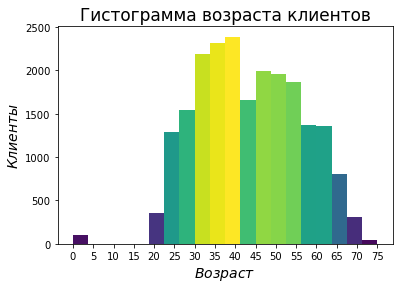

In [10]:
plt.xticks(np.arange((data['dob_years'].min()),
           (data['dob_years'].max() + 5), 5.0))
ax2 = plt.hist(data['dob_years'], bins=20, color='tab:cyan')

# N — счетчик в столбце, bins — нижняя граница
N, bins, patches = plt.hist(data['dob_years'], bins=20)
fracs = N / N.max()  # кодирование цвета по кол-ву
# нормализуем кодирование цвета для полноценного цветового диапазона
norm = colors.Normalize(fracs.min(), fracs.max())
# цикл по полученным объектам, цвет для каждого в отдельности.
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

ax2 = plt.xlabel('$Возраст$', fontsize=14)
ax2 = plt.ylabel('$Клиенты$', fontsize=14)
plt.title('Гистограмма возраста клиентов', fontsize=17)
plt.show()

<font size=2>
В данных о возрасте встречаются нулевые значения, сгруппируем их в соответствии с типом занятости:

In [11]:
data.loc[data['dob_years'] == 0, 'income_type'].value_counts()

сотрудник      55
пенсионер      20
компаньон      20
госслужащий     6
Name: income_type, dtype: int64

<font size=2>
Посчитаем медианные значения возраста в сответствии с типом занятости:

In [12]:
median_dob_years = data.groupby('income_type')['dob_years'].median()
median_dob_years

income_type
безработный        38.0
в декрете          39.0
госслужащий        40.0
компаньон          39.0
пенсионер          60.0
предприниматель    42.5
сотрудник          39.0
студент            22.0
Name: dob_years, dtype: float64

<font size=2>
Заменим нулевые значения возраста на медианные в соответствии с типом занятости:

In [13]:
data.loc[(data['dob_years'] == 0) & (data['income_type'] ==
                                     'сотрудник'), 'dob_years'] = median_dob_years[6]
data.loc[(data['dob_years'] == 0) & (data['income_type'] ==
                                     'пенсионер'), 'dob_years'] = median_dob_years[4]
data.loc[(data['dob_years'] == 0) & (data['income_type'] ==
                                     'компаньон'), 'dob_years'] = median_dob_years[3]
data.loc[(data['dob_years'] == 0) & (data['income_type'] ==
                                     'госслужащий'), 'dob_years'] = median_dob_years[2]

In [14]:
# проверяю, не осталось ли пропущенных значений
data.loc[data['dob_years'] == 0, 'dob_years'].value_counts()

Series([], Name: dob_years, dtype: int64)

#### Обработка пропущенных значений трудового стажа

<font size=2>
Посчитаем количество пропущенных значений трудового стажа также в соответствии с типом занятости:

In [15]:
data.loc[data['days_employed'].isnull(), 'income_type'].value_counts()

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

<font size=2>
Суммы пропусков трудового стажа в соответствии с типом занятости совпадают с таковыми для ежемесячного дохода. Можно сделать вывод, что данные в трудовом стаже пропущены только тогда, когда пропущены значения дохода. Возможной причиной пропусков видится не предоставление клиентом данных  о трудовом стаже/доходе по причине отсутствия официального трудоустройства, либо клиент вовсе безработный.

Значения трудового стажа даны в часах **(подсказка преподавателя)**, переведём отрицательные значения в положительные и также для удобства переведём часы в дни:

In [16]:
data['days_employed'] = data['days_employed'].apply(abs)
data['days_employed'] = data['days_employed'] / 24
# data.head(15)

<font size=2>
Пропущенные значения трудового стажа заменим на медианные значения стажа в соответствии с возрастом. Для этого выделим возрастные группы клиентов в соответствии с общемировой практикой сегментирования потребителей:
- до 24 лет;

- 25 - 44 года;

- 45 - 64 года;

- 65 лет и старше.

<font size=2>
напишем функцию, которая принимает возраст клиента и возвращает возрастную категорию:

In [17]:
def age_group(age):
    if age <= 24:
        return 'до 24'
    elif 25 <= age <= 44:
        return '25-44'
    elif 45 <= age <= 64:
        return '45-64'
    else:
        return '65+'


# проверка, добавляем в таблицу столбец с возрастной категорией, дополнительно оцениваем размер получившихся категорий.
data['age_group'] = data['dob_years'].apply(age_group)
# data.head(30)
data['age_group'].value_counts()

25-44    10934
45-64     8815
65+        899
до 24      877
Name: age_group, dtype: int64

<font size=2>
Для каждой возрастной группы найдём медианное значение трудового стажа:

In [18]:
median_days_employed = data.groupby('age_group')['days_employed'].median()
median_days_employed

age_group
25-44       63.901467
45-64      181.518666
65+      15012.676346
до 24       31.022589
Name: days_employed, dtype: float64

<font size=2>
Заменим нулевые значения стажа на медианные в соответствии с возрастной категорией:

In [19]:
# категория 'до 24'
data.loc[(data['days_employed'].isnull()) & (data['age_group']
                                             == 'до 24'), 'days_employed'] = median_days_employed[3]
# категория '25-44'
data.loc[(data['days_employed'].isnull()) & (data['age_group']
                                             == '25-44'), 'days_employed'] = median_days_employed[0]
# категория '45-64'
data.loc[(data['days_employed'].isnull()) & (data['age_group']
                                             == '45-64'), 'days_employed'] = median_days_employed[1]
# категория '65+'
data.loc[(data['days_employed'].isnull()) & (data['age_group']
                                             == '65+'), 'days_employed'] = median_days_employed[2]

#### Обработка значений количества детей

<font size=2>
Заменим некорректные значения "-1" и "20" соответственно на "1" и "2". Данные аномальные значения скорее всего вызванны человеческим фактором - опечаткой, при занесении данных.

In [20]:
data['children'] = data['children'].replace(-1, 1)
data['children'] = data['children'].replace(20, 2)

data['children'].value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

**Вывод**

In [21]:
# выведем общую информацию о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
 12  age_group         21525 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 2.1+ MB


<font size=2>
Все пропуски в таблице заполнены:

- значения трудового стажа заменены на медианы в соответствии с возрастной категорией;
- нулевые возрастные значения заменены на медианные по типу занятости клиентов;
- пропущенные значения ежемесячного дохода заменены на медианные по типу занятости клиентов.

### Замена типа данных

<font size=2>Выведем информацию о типах данных в таблице:

In [22]:
data.dtypes

children              int64
days_employed       float64
dob_years             int64
education            object
education_id          int64
family_status        object
family_status_id      int64
gender               object
income_type          object
debt                  int64
total_income        float64
purpose              object
age_group            object
dtype: object

<font size=2>Для дальнейшего удобства в работе, в т.ч. и визуальной работе с таблицей, значения трудового стажа, возраста клиентов и ежемесячного дохода, представленные числами с плавающей точкой, заменим их на целочисленные.

In [23]:
data['days_employed'] = data['days_employed'].astype('int')
data['dob_years'] = data['dob_years'].astype('int')
data['total_income'] = data['total_income'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   days_employed     21525 non-null  int32 
 2   dob_years         21525 non-null  int32 
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int64 
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int64 
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int64 
 10  total_income      21525 non-null  int32 
 11  purpose           21525 non-null  object
 12  age_group         21525 non-null  object
dtypes: int32(3), int64(4), object(6)
memory usage: 1.9+ MB


In [24]:
# data.head(10)
# Точность до 6 знака после запятой нам в расчётах не нужна, а таблица стала выглядеть легче.

<font size=2>
**Вывод**

Для перевода данных использовали метод 'astype', поскольку выполнили предобработку пропущенных значений в указанных столбцах.

### Обработка дубликатов

<font size=2>
Перед началом поиска дубликатов приведём данные в ячейках с образованием к нижнему регистру, чтобы исключить в дальнейшем при поиске дубликатов одинаковых значений типа "среднее", "Среднее", "СРЕДНЕЕ", как 3-х разных, что неверно.

In [25]:
data['education'].value_counts()
# до изменения регистра имеем челых 15 разных значений образования

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

In [26]:
wrong_edu_high = 0
for education in data['education']:
    if education == 'ВЫСШЕЕ' or education == 'Высшее':
        wrong_edu_high += 1

# wrong_edu_high

In [27]:
# приводим таблицу к нижнему регистру
data['education'] = data['education'].str.lower()
data['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

In [28]:
# дополнительно посчитаем на примере ячеек с высшем образованием долю неправильно заполненных ячеек:
sum_edu_high = data[data['education'] == 'высшее']['education'].count()


print('кол-во неправильно заполненных ячеек:', wrong_edu_high)
print('доля неправильно заполненных ячеек от общего числа:{:.2%}', format(
    wrong_edu_high/sum_edu_high))

кол-во неправильно заполненных ячеек: 542
доля неправильно заполненных ячеек от общего числа:{:.2%} 0.10304182509505704


<font size=2>Теперь посчитаем число дубликатов во всей таблице:

In [29]:
data.duplicated().sum()

71

<font size=2>Удаляем все дубликаты и проверяем таблицу ещё раз.

In [30]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

<font size=2>
**Вывод**

Необходимо обратить внимание на столбец с данными об образовании. Судя по разбросу значений ячейки заполняются вручную, что приводит к дублированию значений. Например в данных о высшем образовании неправильно заполены данные 10,30% процентах значений. Значений о среднем образовании кратно больше, т.о. и процент неправильных значений может быть значительно больше.

Оптимальным решением видится замена ручного ввода данных об образовании на выпадающий список.

<div class="alert alert-success">

<b>Ревьюер:</b> Абсолютно верно.

</div>

### Лемматизация

<font size=2>Посчитаем все варианты целей кредита и их количество:

In [31]:
data['purpose'].value_counts()

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
покупка жилья                             646
жилье                                     646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

<font size=2>
Многие значения цели кредита названы похожим образом, но несут в себе схожий смысл.

Ключевыми можно выделить основные цели кредита:
- операции с недвижимостью/жильем;
- приобретение автомобиля;
- получение образования;
- кредиты на свадьбу.

Проведём лемматизацию:

In [32]:
# функция, которая пройдёт по значения столбца с целью кредита:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()


# for word in data['purpose']:
#p = morph.parse(word)[0]
# print(p.normal_form)

words = []
for word in data['purpose']:
    p = morph.parse(word)[0]
    word.append(p.normal_form)
data['purpose'] = data['purpose'].apply(word)
data.head()

ModuleNotFoundError: No module named 'pymorphy2'

In [ ]:
# Посмотрим все возможные категории целей кредита после лемматизации:
data['purpose'].value_counts()

<font size=2>
**Вывод**

После лемматизации столбец с целями кредита стал понятнее, что упрощает дальнейший анализ данных и при этом сохраняет основной смысл цели кредита.

<div class="alert alert-success">

<b>Ревьюер:</b> Постарайся не делать грамматических ошибок, особенно в итоговом выводе.

С выводом согласен.


</div>

### Категоризация данных

<font size=2>
Ранее в ходе исследования данные были откатегорированы по возрасту - при устранении пропущенных значений и цели кредита - при лемматизации.

Для ответа на вопросы исследования  потребуется провести ещё категоризацию - по доходам. 

Посмотрим, какой уровень дохода представлен в датасете:

In [ ]:
data.sort_values(by='total_income')

<font size=2>
Уровень дохода лежит в промежутке от ≈20 тыс. рублей до 2.3 млн.рублей.

Статистика разделяет уровень жизни россиян в зависимости от доходов на 8 категорий от «крайней нищеты» до «сверхбогатства». Излишняя категоризация в данном исследовании нам не нужна и скорее будет мешать, поэтому упростим её и выделим 4-е категории заработка:
- низкий доход - до 50 тыс.рублей в месяц;
- средний доход - до 100 тыс.рублей в месяц;
- высокий доход - до 200 тыс.рублей в месяц;
- сверхвысокий доход - свыше 200 тыс.рублей в месяц.

<div class="alert alert-success">

<b>Ревьюер:</b> И снова похвалю тебя за использование внешних источников информации. Можно было бы использовать только математику, но для проведения хорошего анализа важно, чтобы данные имели точки соприкосновения с исследуемым миром.

</div>

In [ ]:
# напишем функцию, которая ежемесячный доход клиента и возвращает категорию заработка:
def total_income_group(income):
    if income <= 50000:
        return 'низкий доход'
    elif 50001 <= income <= 100000:
        return 'средний доход'
    elif 100001 <= income <= 200000:
        return 'высокий доход'
    else:
        return 'сверхвысокий доход'


# проверка, добавляем в таблицу столбец с категорией заработка, дополнительно оцениваем размер получившихся категорий.
data['total_income_group'] = data['total_income'].apply(total_income_group)
# data.head(10)
data['total_income_group'].value_counts()

<font size=2>
**Вывод**

Категоризация данных позволила нам удобно сгруппировать необходимые для решешения текущих и задач, возможных в дальнейшем. Группировка данных проводилась с помощью функции с заданными условиями и с помощью метода apply. 

Благодаря категоризации по возрасту мы увидели, что больше всего клиентов в возрастных группах "25-44",их доля от общего числа ≈50%  и "45-64" лет, с долей в ≈40%. Это может свидетельствовать о том, что банки охотнее выдают кредиты платежеспособным гражданам в работоспособном возрасте, доли клиентов "пенсионеров" и "студентов" значительно ниже, на них приходятся оставшиеся 10% от общего числа.

Категоризация по целям кредита позволила увидеть нам, что клиенты чаще всего берут кредит на приобретения недвижимости, в 50% всех случаев, второе место, можно сказать, делят между собой приобретение автомобиля - 20% и кредиты на образование - 19%, кредиты на свадьбу в 11% случаев замыкают этот список.

Категоризация по уровню дохода также показывает нам, что люди с низким доходом не могут позволить себе кредит, также как это могут позволить люди со средним и высоким доходом, не говоря уже о людях со сверхвысоким доходом.

Основной целью анализа является определние влияния семейного положение и количества детей клиента на факт погашения кредита в срок. Категоризировать количество детей нет необходимости, т.к. их количество и будет как раз категорями, а неккоректные значения в этом столбце мы исправили на этапе предобработки исходных данных. Данные о семейном положении представлены корректно, их так же нет необходимости категоризировать.

<div class="alert alert-success">


<b>Ревьюер:</b> Отличный вывод, сразу видно серьезное отношение к исследованию.
</div>

## Шаг 3. Ответьте на вопросы

<div class="alert alert-warning">

<b>Ревьюер:</b> Библиотеки импортировал, а графики не построил. Почему? Будет здорово, если попробуешь.
</div>

<a id="error_2"></a> 
<div class="alert alert-danger">

<b>Ревьюер:</b> По ТЗ в проекте нужно использовать сводные таблицы. Пожалуйста, примени их в этом блоке.

</div>

<div class="alert alert-info">

<b>Студент:</b>
<font size=2>
Моя невнимательность, за ходом работы я больше следил по чек-листу и упустил из виду необходимость создания сводных таблиц. В этом же разделе я добавил к сводным таблицам хитмапы.
<font size=2> 
Прим. *Я не совсем уверен в правильности своих действий, стоило ли мне полностью переоформлять данный раздел, посчитал, что будет удобным, если ответы по замечаниям я выведу сразу после самого замечания.*
</div>

<div class="alert alert-success">

<b>Ревьюер v2:</b> Достаточно было использовать сводную таблицу один раз, чтобы понять, что ты в них освоился.

</div>

<font size=2>Сводная таблица задолженностей в зависимости от возраста и уровня дохода:

In [ ]:
data_pivot_age_income = data.pivot_table(
    index=['age_group'], columns='total_income_group', values='debt', aggfunc='sum')
data_pivot_age_income

<font size=2>Для наглядности представим таблицу в виде тепловой карты:

In [ ]:
seaborn.heatmap(data_pivot_age_income, cmap='mako',
                linecolor='white', linewidths=3)

<font size=2>
Отчётливо видно, что самыми несознательными оказалиcь клиенты в возрастной категории "25-44" с высоким доходом.

Теперь посмотрим, как влияет цель кредита на количество задолженностей:

In [ ]:
data_pivot_age_purpose = data.pivot_table(
    index=['age_group'], columns='purpose', values='debt', aggfunc='sum')
data_pivot_age_purpose

In [ ]:
seaborn.heatmap(data_pivot_age_purpose, cmap='mako',
                linecolor='white', linewidths=3)

<font size=2>Молодые и платежеспособные клиенты, опять в лидерах, причём в почти половине случаев от общего числа задолженностей в своей категории у них приходится на просрочки в категории недвижимость.

In [ ]:
# data_pivot_all=data.pivot_table(index=['family_status', 'children'],columns='total_income_group', values='debt',aggfunc='sum')
# total_income_group = ['высокий доход','низкий доход','сверхвысокий доход','средний доход']
# data_pivot_all.style.highlight_max(color='red', subset=total_income_group).highlight_min(color='yellowgreen', subset=total_income_group)

<div class="alert alert-danger">

<b>Ревьюер v2:</b> Ты меня поставил в тупик, честно. С одной стороны, ты огромный молодец, что использовал визуализацию! С другой, твои выводы начали противоречить друг другу. Причину я напишу в конце. Так что листай дальше. =) 

</div>

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [ ]:
debt_children = pd.DataFrame()  # создадим сводную таблицу
debt_children['sum_children'] = data.groupby(
    'children')['debt'].sum()  # сумма задолженностей по детям
# группирруем по количеству детей, без задолженности
debt_children['count_children'] = data.groupby('children')['debt'].count()
# результирующая - заолженности/без задолженности
debt_children['result_children'] = (
    debt_children['sum_children'] / debt_children['count_children'])
# для удобства расположим результаты по убыванию результирующей
debt_children.sort_values('result_children', ascending=False)

<font size=2>
**Вывод**

С увеличением количества детей риск просрочки возрастает, однако люди с одним ребёнком имеют больше просрочек чем люди с 3 детьми. Бездетные клиенты допускают просрочки реже всего. Выборка по клиентам с 5 детьми слишком мала, чтобы можно было делать однозначные выводы.

<div class="alert alert-success">


<b>Ревьюер:</b> Верно.
</div>

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [ ]:
# создадим сводную таблицу, также как и для ответа на превый вопрос, только применим группировку задолженностей относительно семейного статуса
debt_family_status = pd.DataFrame()
debt_family_status['sum_family_status'] = data.groupby('family_status')[
    'debt'].sum()
debt_family_status['count_family_status'] = data.groupby('family_status')[
    'debt'].count()
debt_family_status['result_family_status'] = debt_family_status['sum_family_status'] / \
    debt_family_status['count_family_status']
debt_family_status.sort_values('result_family_status', ascending=False)

<font size=2>
**Вывод**

Наибольшее количество просрочек у клиентов ни разу не бывших в браке и живущих гражданским браком. Можно предположить подтверждения стереотипа, что это люди не готовые к серьёзной жизни - созданию семьи и нежелание брать на себя дополнительную ответственность, в т.ч. и кредитование.

Семейные клиенты, либо имевшие опыт совместной жизни, напротив более дисциплинированные. Судя по всему жизнь в браке, как и ответственность за своих детей, учит их отдавать долги вовремя.

Овдовевшие люди самые ответственные клиенты, видимо сложные жизненные условия учат людей серьёзно обдумывать принимаемые решения, рассчитывать свои финансовые возможности, чтобы не допускать просрочек.

<div class="alert alert-success">


<b>Ревьюер:</b> Статистика подтверждает, что с возрастом люди становятся более ответственными. =)
</div>

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [ ]:
debt_total_income = pd.DataFrame()
debt_total_income['sum_total_income_group'] = data.groupby('total_income_group')[
    'debt'].sum()
debt_total_income['count_total_income_group'] = data.groupby(
    'total_income_group')['debt'].count()
debt_total_income['result_total_income_group'] = debt_total_income['sum_total_income_group'] / \
    debt_total_income['count_total_income_group']
debt_total_income.sort_values('result_total_income_group', ascending=False)

<font size=2>
**Вывод**

Прямой зависимости между доходом и возвратом кредита в срок не наблюдается,сильно меньше просрочек наблюдается у клиентов с самым низким уровнем дохода, это можно объяснить тем, что такие клиенты вынуждены ответственно вести свой бюджет и распоряжаться средствами.

<div class="alert alert-success">


<b>Ревьюер:</b> В этом выводе с тобой не совсем соглашусь. Кроме людей с самыми маленькими доходами, кредитные средства возвращают хорошо люди с большими доходами. То есть более безответственно относится к заемным средствам средний класс. А те, у кого денег очень мало или много денег более серьезно распоряжаются своими деньгами.  
</div>

<div class="alert alert-info">

<b>Студент:</b> <font size=2> Замечание принимаю.

</div>

- Как разные цели кредита влияют на его возврат в срок?

In [ ]:
debt_purpose = pd.DataFrame()
debt_purpose['sum_purpose'] = data.groupby('purpose')['debt'].sum()
debt_purpose['count_purpose'] = data.groupby('purpose')['debt'].count()
debt_purpose['result_purpose'] = debt_purpose['sum_purpose'] / \
    debt_purpose['count_purpose']
debt_purpose.sort_values('result_purpose', ascending=False)

<font size=2>
**Вывод**

Самые ответственные клиенты - приобретающие недвижимость, больше всего просрочек у кредитов на автомобили и образование, кредиты на сводьбу просчачивают реже.

<div class="alert alert-success">

<b>Ревьюер:</b> Согласен. Недвижимость никто не хочет терять.
</div>

## Шаг 4. Общий вывод

<div class="alert alert-info">

<b>Студент:</b><font size=2> Дополнил, переписал вывод.

</div>

<font size=2>
В ходе исследования мы выявили зависимость между семейным положением клиента, количество детей и фактом погашения кредита в срок. Действительно, и семейное положение и количество детей оказывают влияние на факт своевременного возврата кредита:
- Клиенты с браке, либо бывшие в официальном браке - самые ответственные;
- Клиенты состоящие в неофициальном браке, либо не имеющие отношений - наоборот, не могут похвастаться таким же уровнем ответственности, как имеющие за плечами опыт семейной жизни;
- Количество детей на факт своевременного возврата кредита влияет негативно, бездетные допускают просрочки горазда реже, чем клиенты с детьми.

Дополнительно в ходе исследования мы также проверили как влияют на просрочки уровень дохода и цель кредита:
- Ответственно к вопросу возврата кредитных средст относятся небогатые люди и наоборот, люди с очень большими доходами. Их отличительной чертой от т.н. среднего класса является более ответственное отношение к своим деньгам, пускай и в силу разных причин;
- Больше всего должников взяли кредит на автомобиль или образование, меньше всего должников среди приобретающих недвижимость. Что логично, потерять недвижимость, особенно если она единственная, довольно неприятно.

В целях составления более обширной картины о клиентах мы рассмотрели как на факт просрочки влияет возраст клиента:
- Больше всех просрочки допускают клиенты категории '22-44' лет, с высоким уровнем дохода. Похоже, что хороший уровень заработной платы не всегда является залогом хорошей финансовой дисциплины. Стоит отметить, что почти половина от общего числа задолженностей у них приходится на категорию 'недвижимость';
- Старшие возрастные категории показывают себя лучше, причем и категория '45-64', и '65+'. Дисциплина и финансовая грамотность, судя по всему, приходят с годами.

На основе проведённого анализа мы можем попробовать составить портрет идеального клиента - это *человек среднего возраста, семейный либо бывший в браке, не имеющий детей и не с низким достатком, желающий приобрести недвижимость.* Такой человек скорее всего умеет нести ответственность (в силу опыта семейной жизни), хороший достаток косвенно подтверждает его грамостность и дисциплинированность, у него есть цель - недвижимость, но нет сдерживающих факторов в виде детей.

В дальнейшем для составления более точного портрета идеального клиента мы можем дополнительно рассмотреть зависимости задолженности от остальных исходных данных - пол, образование, тип занятости.

<a id="error_3"></a> 
<div class="alert alert-danger">

<b>Ревьюер:</b> В течении всего проекты ты делал подробные и последовательные выводы. А финальный вывод написал короче, чем некоторые промежуточные. Выводы – это лицо аналитика. Конечный заказчик будет читать финальный вывод и только его. Добавь информации о проведенном исследовании, разбей по пунктам, сделай красиво, чтобы было понятно, что проведено настоящее исследование и выводу можно верить. Тем более, что у тебя уже все написано.
</div>

<div class="alert alert-info">

<b>Студент:</b> <font size=2> Артём, спасибо большое за все комментарии! В силу малого опыта и большого объёма новой информации знания в голове как следует ещё не структурированы, подсказки как заккоментировать функцию или упростить код, которые наблюдаешь не в тренажере, а уже в тетрадке, помогают собирать мысли в кучу! :)

</div>

<div class="alert alert-danger">

<b>Ревьюер:</b>  Сергей, проект еще не принят, остались последние штрихи.
Хочу отметить, что ты делаешь хорошие выводы. Они подробные и последовательные, а это очень важный этап при проведении исследования, поскольку цель любого исследования — это вывод и формулировка рекомендаций.

Спасибо за хорошую работу, проверял ее с удовольствием. Молодец!

Для удобства поиска я добавил тебе ссылки.

* [Описание данных](#error_1)
* [Сводная таблица](#error_2)
* [Финальный вывод](#error_3)
    
Жду правок =)


</div>

<div class="alert alert-success">

<b>Ревьюер v2:</b> Тебе спасибо за старания! По поводу опыта, не переживай, на этом курсе ты его точно получишь. И по мере прохождения курса отточишь свои навыки.
    
Всегда рад помочь.
</div>
<div class="alert alert-danger">

<b>Ревьюер v2:</b> Теперь по поводу противоречий в выводах. Ошибка возникла из-за того, что ты считал абсолютные числа, а не проценты. И если посмотришь количество кредитов, оформленных на недвижимость, людьми в браке или без детей, то увидишь, что это самые большие категории. У тебя отличный проект, просто ты сам себя запутал при выполнении дополнительного задания, поэтому не буду тебя мучать. Убери из вывода информацию, полученную на основании абсолютных чисел, и отправляй проект на проверку.
</div>

<div class="alert alert-info">

<b>Студент:</b><font size=2> Я скрыл эту противоречивую сводную таблицу и выводы соответственно. Для закрепления материала потренируюсь в дальнейшем, как сделать не противоречащий всему исследованию свод.
    </div>

<div class="alert alert-success">

<b>Ревьюер v3:</b> На самом деле я написал не только про последнюю таблицу, но и про тепловые карты. И они непротиворечивы, они показывают верную информацию, но в абсолютных числах. Из них мы узнаем сколько и в каких категориях просроченных платежей. Но не можем на основании этих данных сравнивать категории. Главное учти на будущее, если категории разделены неравномерно, то смотри в долях (процентах).

Желаю тебе успехов в дальнейшем обучении и во всех твоих начинаниях. =)


</div>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.